# Growth analysis
We expand on [Analysis.ipynb](Analysis.ipynb).
 - Use a better measure of the age of a report (simple approach in [Analysis.ipynb](Analysis.ipynb) wasn't so good for old reports).
 - Analyze the peaks (see http://hjstein.blogspot.com/2020/04/covid-19-nyc-stats-not-what-they-seem.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
def pltdflt(figsize=(12, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid(True, which="minor", linestyle="--")
    plt.grid(True, which="major", color="0.5")
    return fig, ax

In [3]:
hdat = pd.read_csv("../history.csv")
hdat.head()

,DATE_OF_INTEREST,AS_OF,"Cases/day, 7 day avg",DEATH_COUNT,"Deaths/day, 7 day avg",HOSPITALIZED_CASE_COUNT,"Hospitalized/day, 7 day avg",NEW_COVID_CASE_COUNT
0,2020-03-02,2020-03-26 11:26:41,1.00,NaN,NaN,NaN,NaN,1
1,2020-03-03,2020-03-26 11:26:41,1.50,NaN,NaN,3.0,3.000000,2
2,2020-03-04,2020-03-26 11:26:41,4.00,NaN,NaN,3.0,3.000000,9
3,2020-03-05,2020-03-26 11:26:41,3.25,NaN,NaN,4.0,3.333333,1
4,2020-03-06,2020-03-26 11:26:41,4.20,NaN,NaN,5.0,3.750000,8


In [4]:
hdat["DATE_OF_INTEREST"] = pd.to_datetime(hdat["DATE_OF_INTEREST"])
hdat["AS_OF"] = pd.to_datetime(hdat["AS_OF"])
hdat["Days"] = hdat.groupby("DATE_OF_INTEREST").cumcount()
hdat["Age"] = hdat["AS_OF"] - hdat["DATE_OF_INTEREST"]

In [5]:
firstRpt = hdat[["DATE_OF_INTEREST", "NEW_COVID_CASE_COUNT"]].groupby("DATE_OF_INTEREST").first()
firstRpt.rename(columns={"NEW_COVID_CASE_COUNT": "First"}, inplace=True)
hdat = hdat.merge(firstRpt, how="left", on="DATE_OF_INTEREST")

In [6]:
lastRpt = hdat[["DATE_OF_INTEREST", "NEW_COVID_CASE_COUNT"]].groupby("DATE_OF_INTEREST").last()
lastRpt.rename(columns={"NEW_COVID_CASE_COUNT": "Last"}, inplace=True)
hdat = hdat.merge(lastRpt, how="left", on="DATE_OF_INTEREST")

In [7]:
hdat["Growth"] = hdat["Last"]/hdat["NEW_COVID_CASE_COUNT"]
hdat["Age (days)"] = hdat["Age"].dt.days

In [8]:
df = hdat.pivot_table(index="Age (days)",
                 columns="DATE_OF_INTEREST",
                 values="Growth")

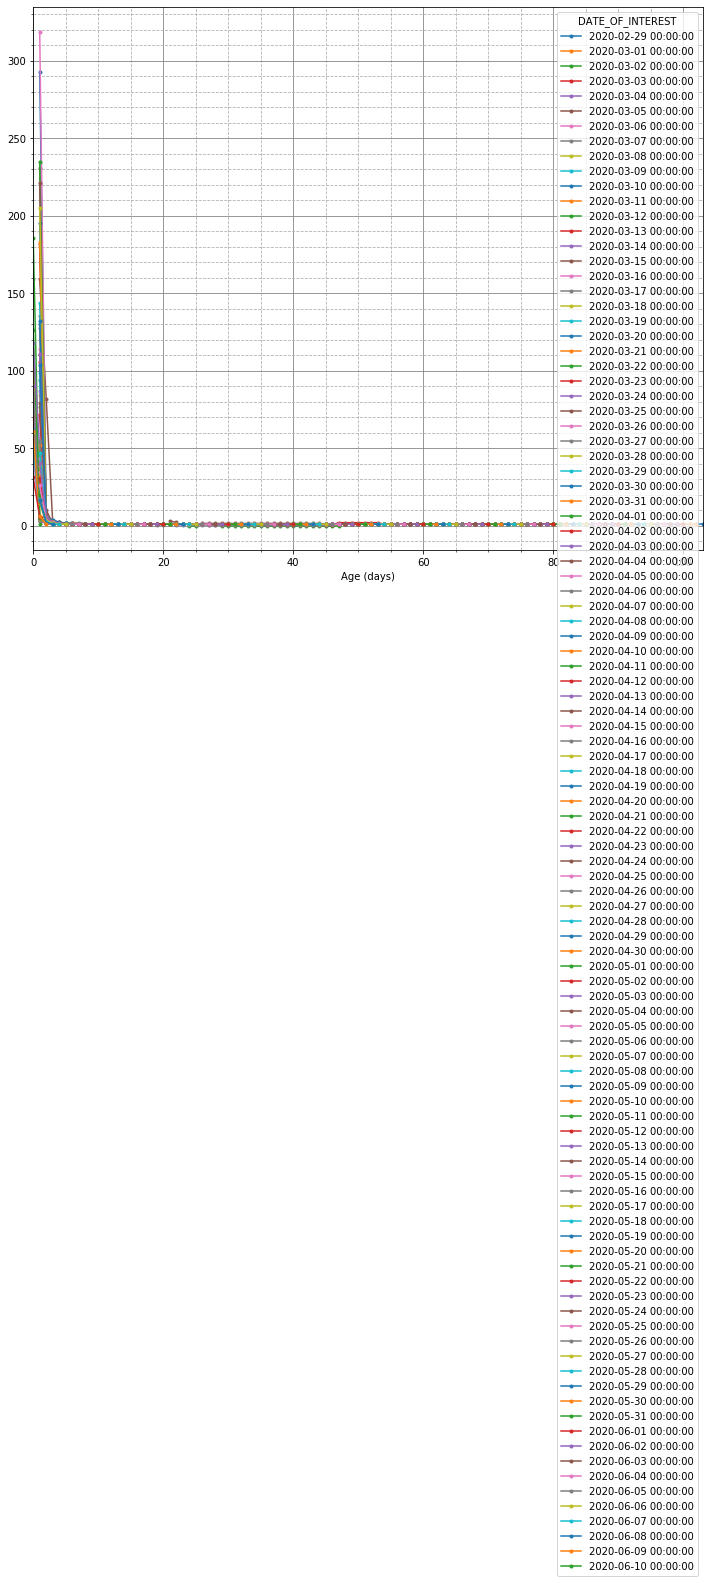

In [9]:
fig, ax = pltdflt()
df.plot(style=".-", ax=ax)

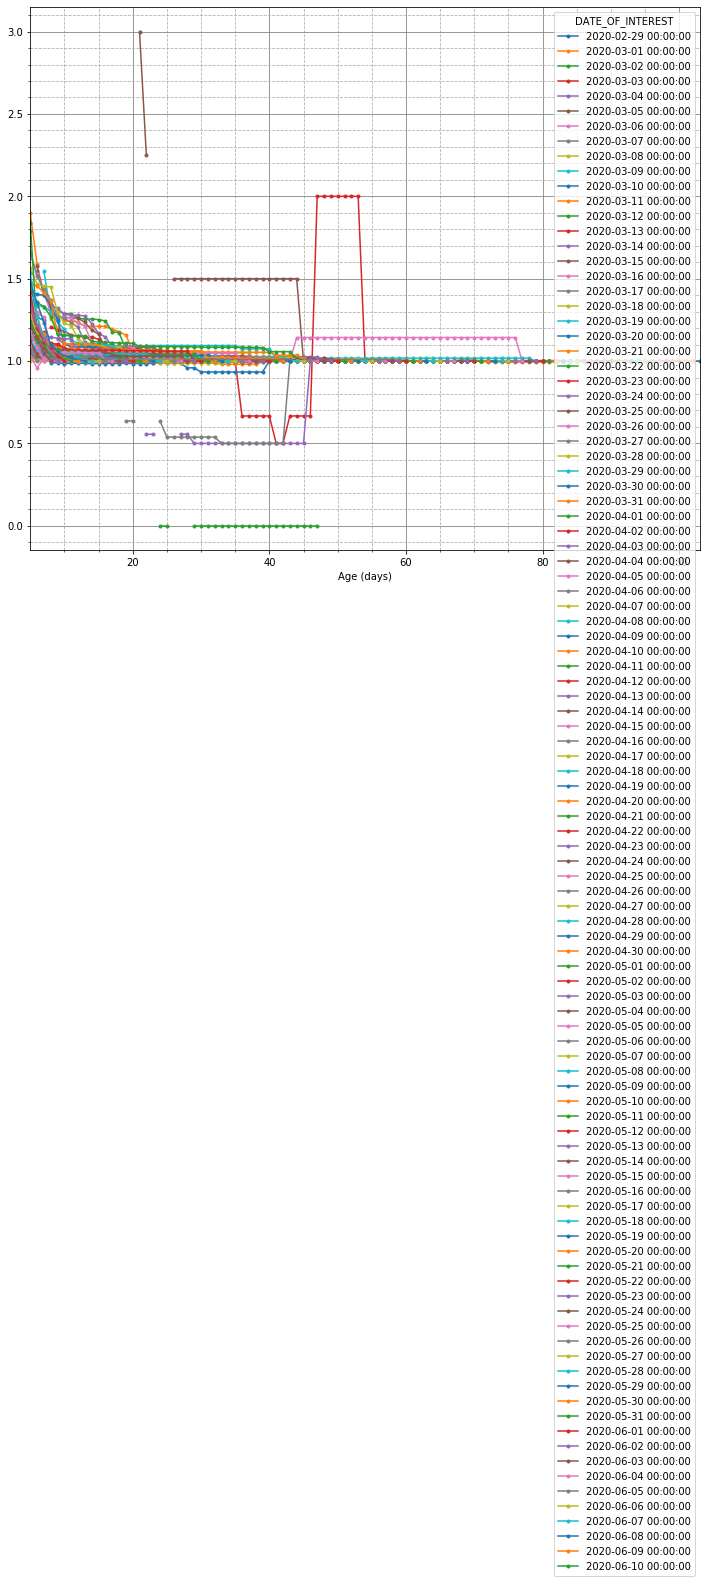

In [10]:
fig, ax = pltdflt()
df[df.index >= 5].plot(style=".-", ax=ax)

In [11]:
peak = hdat.groupby("AS_OF").max()
peak.rename(columns={"Cases/day, 7 day avg": "Cases/day, 7 day avg, Peak",
                     "NEW_COVID_CASE_COUNT": "NEW_COVID_CASE_COUNT, Peak",
                     "Deaths/day, 7 day avg": "Deaths/day, 7 day avg, Peak",
                     "DEATH_COUNT": "DEATH_COUNT, Peak"},
            inplace=True)
hdat = hdat.merge(peak[["Cases/day, 7 day avg, Peak",
                        "NEW_COVID_CASE_COUNT, Peak",
                        "Deaths/day, 7 day avg, Peak",
                        "DEATH_COUNT, Peak"]],
                  on="AS_OF")

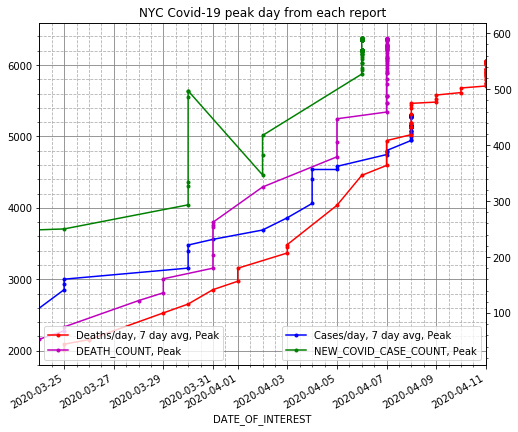

In [12]:
fig, ax = pltdflt(figsize=(8,7))
ax2 = ax.axes.twinx()
for fld, ax3, c in zip(["Cases/day, 7 day avg", "NEW_COVID_CASE_COUNT",
                        "Deaths/day, 7 day avg", "DEATH_COUNT"],
                       [ax, ax, ax2, ax2],
                       ["b", "g", "r", "m"]):
    peak = hdat[hdat[fld] == hdat[fld + ", Peak"]]
    peak = peak.sort_values(["DATE_OF_INTEREST", fld + ", Peak"])
    peak.set_index("DATE_OF_INTEREST")[[fld + ", Peak"]].plot(style=".-", ax=ax3, color=c)

ax.legend(loc=4)
ax2.legend(loc=3)
ax2.yaxis.grid(False, which="both")

plt.title("NYC Covid-19 peak day from each report")
plt.savefig("peakCases.png")
#ax.legend(["Peak avg", "Peak"])

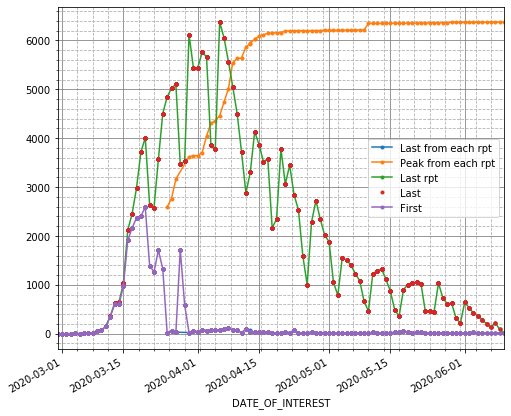

In [13]:
fig, ax = pltdflt(figsize=(8,7))
hdat.groupby("AS_OF").last().set_index("DATE_OF_INTEREST")[["NEW_COVID_CASE_COUNT"]].plot(style=".-", ax=ax)
hdat.groupby("AS_OF").max().set_index("DATE_OF_INTEREST")[["NEW_COVID_CASE_COUNT"]].plot(style=".-", ax=ax)
hdat[hdat["AS_OF"] == np.max(hdat["AS_OF"])].set_index("DATE_OF_INTEREST")[["NEW_COVID_CASE_COUNT"]].plot(style=".-", ax=ax)
hdat.set_index("DATE_OF_INTEREST")[["Last"]].plot(style=".", ax=ax)
hdat.set_index("DATE_OF_INTEREST")[["First"]].plot(style=".-", ax=ax)

ax.legend(["Last from each rpt", "Peak from each rpt", "Last rpt", "Last", "First"])

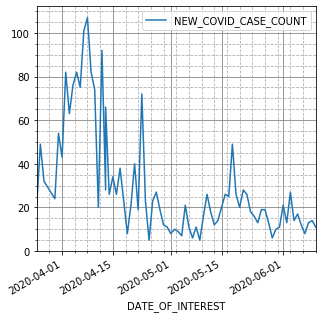

In [14]:
fig, ax = pltdflt(figsize=(5,5))
hdat.groupby("AS_OF").last().set_index("DATE_OF_INTEREST")[["NEW_COVID_CASE_COUNT"]].plot(ax=ax)

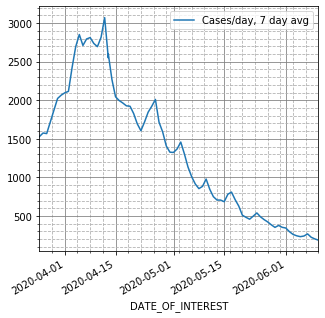

In [15]:
fig, ax = pltdflt(figsize=(5,5))
hdat.groupby("AS_OF").last().set_index("DATE_OF_INTEREST")[["Cases/day, 7 day avg"]].plot(ax=ax)

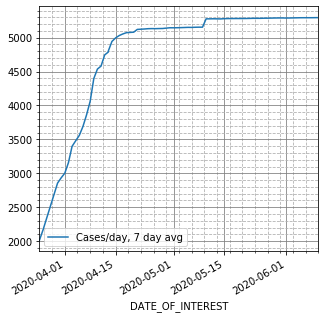

In [16]:
fig, ax = pltdflt(figsize=(5,5))
hdat.groupby("AS_OF").max().set_index("DATE_OF_INTEREST")[["Cases/day, 7 day avg"]].plot(ax=ax)

In [17]:
hdat.groupby("AS_OF").max()

,DATE_OF_INTEREST,"Cases/day, 7 day avg",DEATH_COUNT,"Deaths/day, 7 day avg",HOSPITALIZED_CASE_COUNT,"Hospitalized/day, 7 day avg",NEW_COVID_CASE_COUNT,Days,Age,First,Last,Growth,Age (days),"Cases/day, 7 day avg, Peak","NEW_COVID_CASE_COUNT, Peak","Deaths/day, 7 day avg, Peak","DEATH_COUNT, Peak"
AS_OF,,,,,,,,,,,,,,,,,
2020-03-26 11:26:41,2020-03-25,2013.714286,53.0,34.142857,492.0,398.142857,2594,0,24 days 11:26:41,2594,4844,230.666667,24,2013.714286,2594,34.142857,53.0
2020-03-27 10:03:51,2020-03-26,2166.428571,68.0,44.142857,575.0,474.857143,2765,1,25 days 10:03:51,2594,5025,102.551020,25,2166.428571,2765,44.142857,68.0
2020-03-27 18:37:24,2020-03-27,2339.571429,75.0,52.285714,598.0,490.428571,3164,2,25 days 18:37:24,2594,5102,159.437500,25,2339.571429,3164,52.285714,75.0
2020-03-31 09:25:56,2020-03-30,2855.285714,122.0,100.000000,702.0,636.285714,3622,3,29 days 09:25:56,2594,6120,255.000000,29,2855.285714,3622,100.000000,122.0
2020-03-31 17:21:32,2020-03-31,2933.142857,136.0,115.857143,769.0,679.857143,3639,4,29 days 17:21:32,2594,6120,100.833333,29,2933.142857,3639,115.857143,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-07 12:04:18,2020-06-06,5293.857143,590.0,549.571429,1694.0,1542.428571,6372,73,99 days 12:04:18,2594,6374,16.666667,99,5293.857143,6372,549.571429,590.0
2020-06-08 12:56:54,2020-06-07,5293.857143,590.0,549.571429,1694.0,1542.428571,6372,74,100 days 12:56:54,2594,6374,16.875000,100,5293.857143,6372,549.571429,590.0
2020-06-09 12:37:29,2020-06-08,5294.000000,590.0,549.571429,1711.0,1549.428571,6372,75,101 days 12:37:29,2594,6374,16.923077,101,5294.000000,6372,549.571429,590.0
